In [2]:
!python -m pip install -q prophet yfinance autots skforecast catboost xgboost holidays pybats

In [74]:
!pip show pybats

In [76]:
# Base
import pandas as pd 
import json
import logging
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True
import warnings
warnings.filterwarnings("ignore")
from joblib import dump, load
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
# Fechas
from datetime import datetime
from datetime import timedelta
from datetime import date
import holidays
# Graficos
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
# Extraer datos
import yfinance as yf
# Modeling
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, mean_absolute_percentage_error
from autots import AutoTS
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from catboost import CatBoostRegressor
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from statsmodels.graphics.tsaplots import plot_acf
from xgboost import XGBRegressor

from pybats.analysis import *
from pybats.point_forecast import *
from pybats.plot import *

$$ACCY = (1 - \frac{|Pronostico -Venta|}{Venta})*100$$

# 1. Load data

In [3]:
msft = yf.Ticker("GOOG")
msft.info
hist = msft.history(period="2y").reset_index().rename(columns={'Date':'ds','Open':'y'})
hist['ds'] = hist['ds'].dt.strftime('%Y-%m-%d')
hist['cap']=hist.y.rolling(window=5).mean().fillna(method='bfill')*1.20
hist['floor']=hist.y.rolling(window=5).mean().fillna(method='bfill')*0.80
hist

,ds,y,High,Low,Close,Volume,Dividends,Stock Splits,cap,floor
0,2022-05-31,113.079002,116.433502,112.572502,114.039001,51302000,0.0,0.0,137.984042,91.989362
1,2022-06-01,114.931503,117.399002,113.550499,114.137001,28630000,0.0,0.0,137.984042,91.989362
2,2022-06-02,114.188004,117.898003,113.307999,117.746002,27472000,0.0,0.0,137.984042,91.989362
3,2022-06-03,115.992500,116.364502,113.667999,114.564003,25052000,0.0,0.0,137.984042,91.989362
4,2022-06-06,116.742500,119.398499,116.528297,117.010498,23786000,0.0,0.0,137.984042,91.989362
...,...,...,...,...,...,...,...,...,...,...
498,2024-05-23,178.779999,179.910004,174.539993,175.059998,14928400,0.0,0.0,213.225597,142.150398
499,2024-05-24,176.520004,177.304001,175.199997,176.330002,11400600,0.0,0.0,213.458397,142.305598
500,2024-05-28,175.740005,178.509995,175.679993,178.020004,15655300,0.0,0.0,213.081599,142.054399
501,2024-05-29,176.809998,178.229996,176.259995,177.399994,15023800,0.0,0.0,212.700000,141.800000


In [11]:
# 1.2 DimTiempo 
start_date = '2014-05-30'
end_date = '2025-12-31'  

DimTiempo = pd.DataFrame({
    'FECHA': pd.date_range(start=start_date, end=end_date, freq='D')
})


# 1.4 DimDS
DimDS = DimTiempo.copy()
DimDS['DS']=np.arange(1,DimTiempo.shape[0]+1,1)

# 1.5 Dimholidays
mx_holidays = holidays.USA()
start_date = '2014-05-01'
end_date = '2024-12-31'
date_range = pd.date_range(start=start_date, end=end_date)
DimHolidays = pd.DataFrame(date_range, columns=['FECHA'])
DimHolidays['HOLIDAY'] = DimHolidays['FECHA'].apply(lambda x: 1 if x in mx_holidays else 0)

# 1.6 DimWeekend
DimWeekend= DimTiempo.copy()
DimWeekend['WEEKEND_X']= DimWeekend['FECHA'].dt.day_of_week
DimWeekend['WEEKEND']= DimWeekend['WEEKEND_X'].apply(lambda x: 1 if x>=5 else 0)
DimWeekend.drop(columns=['WEEKEND_X'],inplace=True)
DimWeekend

,FECHA,WEEKEND
0,2014-05-30,0
1,2014-05-31,1
2,2014-06-01,1
3,2014-06-02,0
4,2014-06-03,0
...,...,...
4229,2025-12-27,1
4230,2025-12-28,1
4231,2025-12-29,0
4232,2025-12-30,0


In [12]:
holidays_USA=\
    pd.concat(
    [
        DimHolidays.query("HOLIDAY==1").reset_index(drop=True).rename(columns={'FECHA':'ds','HOLIDAY':'holiday'}).assign(holiday='usa_holidays',lower_window=-1, upper_window=0)
    ]
)
holidays_USA

,ds,holiday,lower_window,upper_window
0,2014-05-26,usa_holidays,-1,0
1,2014-07-04,usa_holidays,-1,0
2,2014-09-01,usa_holidays,-1,0
3,2014-10-13,usa_holidays,-1,0
4,2014-11-11,usa_holidays,-1,0
...,...,...,...,...
120,2024-09-02,usa_holidays,-1,0
121,2024-10-14,usa_holidays,-1,0
122,2024-11-11,usa_holidays,-1,0
123,2024-11-28,usa_holidays,-1,0


In [13]:
fig = go.Figure()
# Open
fig.add_trace(go.Scatter(x=hist['ds'], y=hist['y'], mode='lines', name='Open',
                         line=dict(color='blue', width=2)))
# High
fig.add_trace(go.Scatter(x=hist['ds'], y=hist['High'], mode='lines', name='High',
                         line=dict(color='green', width=2)))
# Low
fig.add_trace(go.Scatter(x=hist['ds'], y=hist['Low'], mode='lines', name='Low',
                         line=dict(color='red', width=2)))
# Layout
fig.update_layout(
    title='GOOG history',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    #template='plotly_dark', 
    hovermode='x'
)
fig.show()

# 2. Prophet

**Fuente:** https://facebook.github.io/prophet/docs/quick_start.html#python-api

El modelo Prophet es un algoritmo de series temporales desarrollado por Facebook, diseñado para manejar datos con patrones estacionales y tendencias. Es especialmente útil para datos con estacionalidad diaria, semanal y anual, y puede manejar datos faltantes y cambios en las tendencias.

**Ecuación del Modelo Prophet**

El modelo Prophet se puede expresar mediante la siguiente ecuación:

$$y(t) = g(t) + s(t) + h(t) + \epsilon_t$$

Donde:

- $ y(t) $: es el valor observado en el tiempo $ t $.
- $ g(t) $: es la función de tendencia que modela los cambios no periódicos en la serie temporal.
- $ s(t) $: es la función de estacionalidad que captura las variaciones periódicas (como diaria, semanal o anual).
- $ h(t) $: es la función que modela los eventos o días festivos que pueden afectar los valores de la serie temporal.
- $ \epsilon_t $: es el término de error que captura la variabilidad no explicada por el modelo.

### Componentes del Modelo

1. **Tendencia ($g(t)$)**: Puede ser modelada usando dos tipos de funciones:
    - **Lineal**: $g(t) = k t + m$, donde $k$ es la pendiente y $m$ es la intersección.
    - **Crecimiento Logístico**: $$g(t) = \frac{C}{1 + \exp(-k(t - m))}$$, donde $ C $ es la capacidad de saturación, $ k $ es la tasa de crecimiento y $ m $ es el punto medio del crecimiento.

2. **Estacionalidad ($ s(t) $)**: Modelada usando una serie de Fourier para capturar las variaciones periódicas:
    $s(t) = \sum_{n=1}^{N} \left( a_n \cos\left(\frac{2 \pi n t}{P}\right) + b_n \cos\left(\frac{2 \pi n t}{P}\right) \right)$
    Donde $ P $ es el periodo de la estacionalidad (por ejemplo, 365.25 para anual).

3. **Festivos ($ h(t) $)**: Modela el efecto de los eventos especiales o días festivos utilizando variables indicadoras para cada evento.

4. **Ruido ($ \epsilon_t $)**: Captura las irregularidades y ruidos no explicados por los otros componentes del modelo.

El modelo Prophet es robusto, fácil de usar y ofrece una interfaz intuitiva para la previsión de series temporales complejas.


## 2.1 Evaluacion

In [18]:
# Metricas
model = Prophet(
            growth='linear', # linear, flat, logistic. Si ellijes logistic se debe crear una columna llamada 'cap' para cada fila con el valor maximo posible
            #changepoints= 5, # NOT USE puntos de cambio de la serie de tiempo, por default son 25
            #changepoint_range=0.8, # NOT USE esto indica que los 25 puntos se van a poner sobre el primer 80% de las series
            changepoint_prior_scale=0.1, # DEFAULT 0.05 Parametro que modula la felxibilidad de seleccion de puntos de cambio, mientras mas pequeño menor puntos de cambios
            holidays=holidays_USA,
            holidays_prior_scale=0.05
        )
#model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
model.add_seasonality(name='daily', period=1, fourier_order=2, prior_scale=0.05)
model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.05)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10, prior_scale=0.05)
#model.add_regressor('new_users');model.add_regressor('retained_users');model.add_regressor('t2m');
#model.add_regressor('total_usd');model.add_regressor('discount_promo');model.add_regressor('discount_coupon');model.add_regressor('freq_ret')
model.fit(hist[['ds','y']].iloc[0:-30].fillna(method='backfill').fillna(method='bfill').fillna(method='ffill'))

prophet    INFO  Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
prophet    INFO  Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
prophet    INFO  Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


**Comentarios importantes**
- `fourier_order` controla la complejidad de la estacionalidad. Más alto permite que el modelo ajuste patrones más complejos.
- `prior_scale` controla la flexibilidad de la estacionalidad. Más bajo hace que la estacionalidad sea más regular y menos propensa a sobreajustar el ruido en los datos.

In [28]:
test = hist.iloc[-30:][['ds']]
f_t=model.predict(test)

fig = go.Figure()
# Open
fig.add_trace(go.Scatter(x=hist.iloc[0:-30]['ds'], y=hist.iloc[0:-30]['y'], mode='lines', name='Open',
                         line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=f_t[['ds','yhat']]['ds'], y=f_t[['ds','yhat']]['yhat'], mode='lines', name='Pred',
                         line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(x=hist.iloc[-30:]['ds'], y=hist.iloc[-30:]['y'], mode='lines', name='Test',
                         line=dict(color='green', width=2)))

# Layout
fig.update_layout(
    title='MSFT history',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    #template='plotly_dark', 
    hovermode='x'
)
fig.show()

In [29]:
# Error metrics
print('MSE: ', mean_squared_error(y_true=hist.iloc[-30:]['y'].values, y_pred=f_t['yhat'].values))
print('RMSE: ', np.sqrt(mean_squared_error(y_true=hist.iloc[-30:]['y'].values, y_pred=f_t['yhat'].values)))
print('MAE: ', mean_absolute_error(y_true=hist.iloc[-30:]['y'].values, y_pred=f_t['yhat'].values))
print('Max Error: ', max_error(y_true=hist.iloc[-30:]['y'].values, y_pred=f_t['yhat'].values))
print('MAPE: ', mean_absolute_percentage_error(y_true=hist.iloc[-30:]['y'].values, y_pred=f_t['yhat'].values)*100)

MSE:  80.79323213097635
RMSE:  8.988505556040801
MAE:  7.39989751188678
Max Error:  22.10449397449557
MAPE:  4.3343396154315075


In [39]:
# ACCY
real=hist.iloc[-30:]['y'].values
pred=f_t['yhat'].values
assert real.shape== pred.shape
accu=(1- np.abs(pred-real)/real)*100
np.nanmean(accu)

95.6656603845685

## 2.2 Prediccion

In [169]:
model = Prophet(
            growth='linear', # linear, flat, logistic. Si ellijes logistic se debe crear una columna llamada 'cap' para cada fila con el valor maximo posible
            #changepoints= 5, # NOT USE puntos de cambio de la serie de tiempo, por default son 25
            #changepoint_range=0.8, # NOT USE esto indica que los 25 puntos se van a poner sobre el primer 80% de las series
            changepoint_prior_scale=0.1, # DEFAULT 0.05 Parametro que modula la felxibilidad de seleccion de puntos de cambio, mientras mas pequeño menor puntos de cambios
            holidays=holidays_USA,
            holidays_prior_scale=0.05
        )
model.add_seasonality(name='daily', period=1, fourier_order=2, prior_scale=0.05)
model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.05)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10, prior_scale=0.05)
#model.add_regressor('new_users');model.add_regressor('retained_users');model.add_regressor('t2m');
#model.add_regressor('total_usd');model.add_regressor('discount_promo');model.add_regressor('discount_coupon');model.add_regressor('freq_ret')
model.fit(hist[['ds','y']].fillna(method='backfill').fillna(method='bfill').fillna(method='ffill'))

In [172]:
future = model.make_future_dataframe(periods=5).tail(5)
#future['cap']= hist.iloc[-30:].cap.values
#future['floor']= 0# hist.iloc[-30:].floor.values
forecast = model.predict(future)
forecast.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-05-31,168.262888,176.170847,184.116567,168.262888,168.262888,11.770870,11.770870,11.770870,0.108479,...,0.151504,0.151504,0.151504,11.510887,11.510887,11.510887,0.0,0.0,0.0,180.033758
1,2024-06-01,168.402724,175.507648,183.842045,168.402724,168.402724,11.418021,11.418021,11.418021,0.108479,...,-0.027120,-0.027120,-0.027120,11.336662,11.336662,11.336662,0.0,0.0,0.0,179.820745
2,2024-06-02,168.542559,175.386303,183.834495,168.542559,168.542559,11.211994,11.211994,11.211994,0.108479,...,-0.027120,-0.027120,-0.027120,11.130635,11.130635,11.130635,0.0,0.0,0.0,179.754553
3,2024-06-03,168.682394,175.609268,183.750145,168.682394,168.682394,10.907775,10.907775,10.907775,0.108479,...,-0.100055,-0.100055,-0.100055,10.899352,10.899352,10.899352,0.0,0.0,0.0,179.590170
4,2024-06-04,168.822229,175.494951,183.739632,168.822229,168.822229,10.794142,10.794142,10.794142,0.108479,...,0.036224,0.036224,0.036224,10.649439,10.649439,10.649439,0.0,0.0,0.0,179.616371


In [173]:
fig = go.Figure()
# Open
fig.add_trace(go.Scatter(x=hist['ds'], y=hist['y'], mode='lines', name='Open',
                         line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=forecast[['ds','yhat']]['ds'], y=forecast[['ds','yhat']]['yhat'], mode='lines', name='Pred',
                         line=dict(color='red', width=2)))

# Layout
fig.update_layout(
    title='MSFT history',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    #template='plotly_dark', 
    hovermode='x'
)
fig.show()

# 3. AutoTS

AutoTS (Automated Time Series) es una librería de Python diseñada para simplificar y automatizar el proceso de modelado y predicción de series temporales. La librería proporciona herramientas que permiten a los usuarios generar rápidamente modelos precisos de series temporales sin necesidad de una intervención manual significativa en la selección de modelos, ajuste de hiperparámetros y evaluación de rendimiento.

**Referencia**: https://github.com/winedarksea/autots

**Modelos Clásicos**

1. **ARIMA (AutoRegressive Integrated Moving Average)**: Modelo popular para series temporales estacionarias que combina componentes autorregresivos, de media móvil y de diferenciación.
2. **ETS (Error, Trend, Seasonal)**: Modelo que descompone la serie temporal en error, tendencia y estacionalidad.
3. **Prophet**: Modelo desarrollado por Facebook para capturar tendencias y estacionalidades con soporte para eventos especiales y cambios abruptos en las tendencias.

**Modelos de Machine Learning**

1. **Random Forest**: Modelo de ensamble que utiliza múltiples árboles de decisión para mejorar la precisión de las predicciones.
2. **XGBoost**: Modelo de boosting que combina árboles de decisión para realizar predicciones robustas y precisas.

**Modelos de Deep Learning**

1. **LSTM (Long Short-Term Memory)**: Tipo de red neuronal recurrente (RNN) especialmente útil para capturar dependencias a largo plazo en las series temporales.
2. **GRU (Gated Recurrent Unit)**: Variante simplificada de LSTM que también es eficaz para modelar dependencias a largo plazo.

**Otros Modelos**

1. **VAR (Vector AutoRegression)**: Modelo que captura la relación entre múltiples series temporales.
2. **NBEATS**: Modelo avanzado de deep learning diseñado específicamente para series temporales.


## 3.1 Evaluación

In [45]:
C= hist.copy()
C['ds'] = pd.to_datetime(C['ds'])
C_weekly = C.groupby(pd.Grouper(key='ds', freq='W')).mean()
C_weekly = C_weekly.reset_index()
C_weekly['ds'] = C_weekly['ds'].dt.strftime('%Y-%W')
C_weekly['ds_new']= np.arange(1, C_weekly.shape[0]+1,1)
C_weekly

,ds,y,High,Low,Close,Volume,Dividends,Stock Splits,cap,floor,ds_new
0,2022-22,114.547752,117.023752,113.274750,115.121502,33114000.0,0.0,0.0,137.984042,91.989362,1
1,2022-23,115.677951,117.528030,114.815709,115.564699,25442000.0,0.0,0.0,138.809966,92.539977,2
2,2022-24,107.584000,109.655798,106.495970,107.792502,34851600.0,0.0,0.0,132.665904,88.443936,3
3,2022-25,111.854500,114.569124,111.162449,113.817875,31691000.0,0.0,0.0,131.224651,87.483101,4
4,2022-26,113.254198,114.381430,110.882750,111.980800,29754800.0,0.0,0.0,136.855222,91.236814,5
...,...,...,...,...,...,...,...,...,...,...,...
100,2024-18,168.107999,169.688000,165.425998,167.112003,26073360.0,0.0,0.0,199.948801,133.299201,101
101,2024-19,170.185999,171.811798,169.250400,171.167999,16299680.0,0.0,0.0,202.979037,135.319358,102
102,2024-20,171.977402,174.322198,171.447998,173.885995,18626000.0,0.0,0.0,204.531600,136.354400,103
103,2024-21,177.881998,179.167203,176.210999,177.478000,14943900.0,0.0,0.0,211.757759,141.171839,104


<Axes: xlabel='ds'>

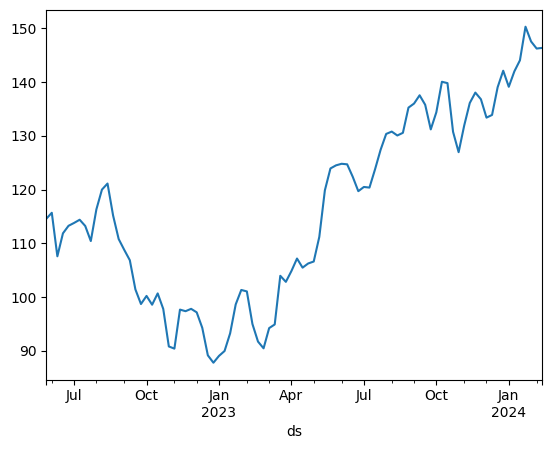

In [60]:
T.y.plot()

In [58]:
T=C_weekly[['ds','y']].iloc[0:-15].fillna(method='backfill').fillna(method='bfill').fillna(method='ffill')
T['ds'] = pd.to_datetime(T['ds'] + '-1', format='%Y-%W-%w')
T=T.set_index('ds')

steps_to_predict= 15

model = AutoTS(
        forecast_length=steps_to_predict,
        frequency='W', # D= Daily , W= Weekly, Y= Yearly, M='Monthly'
        prediction_interval=0.9,
        max_generations=5,
        no_negatives=True, # Todo lo negativo se redondea a 0
        #ensemble='auto', # 'auto', 'simple', 'distance', 'horizontal', 'horizontal-min', 'horizontal-max', "mosaic", "subsample"
        ensemble=['auto'],
        model_list="fast",  # "fast","superfast", "default", "fast_parallel", "univariate"
        # 'ETS', 'GLM', 'UnobservedComponents', 'UnivariateMotif', 'MultivariateMotif', 'Theta', 'ARDL', 'ARCH'
        #model_list=['ETS','UnobservedComponents','GLM','ARCH','Theta', 'ARDL','LastValueNaive','GLS','AverageValueNaive'],
        #model_list=['ETS','UnobservedComponents','GLM','ARCH','Theta','ARDL','LastValueNaive','GLS','AverageValueNaive','ConstantNaive','SeasonalNaive','DynamicFactor',\
        #            'DynamicFactorMQ','VECM','VAR','RollingRegression','RollingRegression','WindowRegression','DatepartRegression','MultivariateRegression',\
        #            'FFT','Cassandra','KalmanStateSpace','LATC'
        #            ],
        transformer_list="fast",  # "fast","superfast",
        drop_most_recent=1,
        num_validations=3,
        validation_method="backwards", # 'even', 'backwards', or 'seasonal n',
        verbose=0, # -1
        constraint=0.4,  # forecasts would not be allowed to go above max(training data) + 1.3 * st.dev(training data), as well as the reverse on the minimum side 
)
model.fit(T)

Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 7 in generation 0: DatepartRegression
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VECM') in model 23 in generation 0: VECM
Template Eval Error: ValueError('Only gave one variable to VECM') in model 24 in generation 0: VECM
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 27 in generation 0: DatepartRegression
Template Eval Error: ValueError('Only gave one variable to VECM') in model 31 in generation 0: VECM
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 32 in generation 0: UnivariateMotif
Template Eval Error: ValueError('negative dimensions are not allowed') in model 42 in ge

Initiated AutoTS object with best model: 
FFT
{'fillna': 'ffill', 'transformations': {'0': 'PowerTransformer', '1': 'DifferencedTransformer', '2': 'bkfilter', '3': 'HPFilter'}, 'transformation_params': {'0': {}, '1': {}, '2': {}, '3': {'part': 'trend', 'lamb': 129600}}}
{'n_harmonics': 10, 'detrend': 'linear'}
Validation: 0, 1, 2, 3
SMAPE: 2.9968856328792475, 3.7650103348598294, 2.3385374429134544, 8.59796385571954
MAE: 4.199345786654661, 4.96162792436512, 2.7142018486094894, 7.9803489469248055
SPL: 1.0783703466927128, 0.9753612323398388, 1.435337176720148, 2.883452535591089

In [61]:
pred=model.predict(forecast_length=steps_to_predict) # Tambien pronostica otras variables
pred    

Prediction object: 
Return .forecast, 
 .upper_forecast, 
 .lower_forecast 
 .model_parameters 
 .transformation_parameters

In [62]:
pred.model_parameters

{'n_harmonics': 10, 'detrend': 'linear'}

In [63]:
pred.transformation_parameters

{'fillna': 'ffill',
 'transformations': {'0': 'PowerTransformer',
  '1': 'DifferencedTransformer',
  '2': 'bkfilter',
  '3': 'HPFilter'},
 'transformation_params': {'0': {},
  '1': {},
  '2': {},
  '3': {'part': 'trend', 'lamb': 129600}}}

In [69]:
f_t= pred.forecast
f_t=f_t.reset_index().rename(columns={'index':'ds'})
f_t['ds_new']= np.arange(C_weekly.iloc[0:-15].ds_new.max()+1, C_weekly.iloc[0:-15].ds_new.max()+1+15,1)
f_t

,ds,y,ds_new
0,2024-02-18,147.313822,91
1,2024-02-25,148.489607,92
2,2024-03-03,149.732069,93
3,2024-03-10,151.032165,94
4,2024-03-17,152.378886,95
5,2024-03-24,153.763211,96
6,2024-03-31,155.180840,97
7,2024-04-07,156.632842,98
8,2024-04-14,157.178482,99
9,2024-04-21,157.178482,100


In [70]:
f_t= pred.forecast
f_t=f_t.reset_index().rename(columns={'index':'ds'})
f_t['ds_new']= np.arange(C_weekly.iloc[0:-15].ds_new.max()+1, C_weekly.iloc[0:-15].ds_new.max()+1+15,1)

fig = go.Figure()
# Open
fig.add_trace(go.Scatter(x=C_weekly.iloc[0:-15]['ds_new'], y=C_weekly.iloc[0:-15]['y'], mode='lines', name='Open',
                         line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=f_t[['ds_new','y']]['ds_new'], y=f_t[['ds_new','y']]['y'], mode='lines', name='Pred',
                         line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(x=C_weekly.iloc[-15:]['ds_new'], y=C_weekly.iloc[-15:]['y'], mode='lines', name='Test',
                         line=dict(color='green', width=2)))

# Layout
fig.update_layout(
    title='GOOG history',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    #template='plotly_dark', 
    hovermode='x'
)
fig.show()

In [72]:
print('MSE: ', mean_squared_error(y_true=C_weekly.iloc[-15:]['y'].values, y_pred=f_t['y'].values))
print('RMSE: ', np.sqrt(mean_squared_error(y_true=C_weekly.iloc[-15:]['y'].values, y_pred=f_t['y'].values)))
print('MAE: ', mean_absolute_error(y_true=C_weekly.iloc[-15:]['y'].values, y_pred=f_t['y'].values))
print('Max Error: ', max_error(y_true=C_weekly.iloc[-15:]['y'].values, y_pred=f_t['y'].values))
print('MAPE: ', mean_absolute_percentage_error(y_true=C_weekly.iloc[-15:]['y'].values, y_pred=f_t['y'].values)*100)

MSE:  117.83779734451913
RMSE:  10.855311941373179
MAE:  8.531368566559763
Max Error:  20.703516041427264
MAPE:  5.341909020588943


## 3.2 Predicción

In [73]:
T=C_weekly[['ds','y']].fillna(method='backfill').fillna(method='bfill').fillna(method='ffill')
T['ds'] = pd.to_datetime(T['ds'] + '-1', format='%Y-%W-%w')
T=T.set_index('ds')

steps_to_predict= 15

model = AutoTS(
        forecast_length=steps_to_predict,
        frequency='W', # Daily , W= Weekly, Y= Yearly
        prediction_interval=0.9,
        max_generations=5,
        no_negatives=True, # Todo lo negativo se redondea a 0
        #ensemble='auto', # 'auto', 'simple', 'distance', 'horizontal', 'horizontal-min', 'horizontal-max', "mosaic", "subsample"
        ensemble=['auto'],
        model_list="fast",  # "fast","superfast", "default", "fast_parallel", "univariate"
        # 'ETS', 'GLM', 'UnobservedComponents', 'UnivariateMotif', 'MultivariateMotif', 'Theta', 'ARDL', 'ARCH'
        #model_list=['ETS','UnobservedComponents','GLM','ARCH','Theta', 'ARDL','LastValueNaive','GLS','AverageValueNaive'],
        #model_list=['ETS','UnobservedComponents','GLM','ARCH','Theta','ARDL','LastValueNaive','GLS','AverageValueNaive','ConstantNaive','SeasonalNaive','DynamicFactor',\
        #            'DynamicFactorMQ','VECM','VAR','RollingRegression','RollingRegression','WindowRegression','DatepartRegression','MultivariateRegression',\
        #            'FFT','Cassandra','KalmanStateSpace','LATC'
        #            ],
        transformer_list="fast",  # "fast","superfast",
        drop_most_recent=1,
        num_validations=3,
        validation_method="backwards", # 'even', 'backwards', or 'seasonal n',
        verbose=0, # -1
        constraint=0.4,  # forecasts would not be allowed to go above max(training data) + 1.3 * st.dev(training data), as well as the reverse on the minimum side 
)
model.fit(T)

Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 7 in generation 0: DatepartRegression
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VECM') in model 23 in generation 0: VECM
Template Eval Error: ValueError('Only gave one variable to VECM') in model 24 in generation 0: VECM
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 27 in generation 0: DatepartRegression
Template Eval Error: ValueError('Only gave one variable to VECM') in model 31 in generation 0: VECM
Template Eval Error: ValueError('negative dimensions are not allowed') in model 42 in generation 0: Cassandra
Template Eval Error: ValueError('Only gave one variable to VAR') in model 51 in generation 0: VAR
Template Eval

Initiated AutoTS object with best model: 
RRVAR
{'fillna': 'ffill', 'transformations': {'0': 'MinMaxScaler', '1': 'DifferencedTransformer', '2': 'HPFilter', '3': 'Log'}, 'transformation_params': {'0': {}, '1': {}, '2': {'part': 'trend', 'lamb': 129600}, '3': {}}}
{'method': 'dmd', 'rank': 1, 'maxiter': 200}
Validation: 0, 1, 2, 3
SMAPE: 4.822544359229267, 1.8034035298275177, 3.9980872907297327, 4.502222840612715
MAE: 7.508434309027956, 2.4994362109273016, 5.255556941393473, 5.245880880186578
SPL: 1.2158899423350167, 0.6292090500897101, 0.8566695335991364, 1.2489788810143745

In [68]:
pred=model.predict(forecast_length=steps_to_predict) # Tambien pronostica otras variables
pred    

Prediction object: 
Return .forecast, 
 .upper_forecast, 
 .lower_forecast 
 .model_parameters 
 .transformation_parameters

In [72]:
f_t= pred.forecast
f_t=f_t.reset_index().rename(columns={'index':'ds'})
f_t['ds_new']= np.arange(C_weekly.ds_new.max()+1, C_weekly.ds_new.max()+1+15,1)

fig = go.Figure()
# Open
fig.add_trace(go.Scatter(x=C_weekly['ds_new'], y=C_weekly['y'], mode='lines', name='Open',
                         line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=f_t[['ds_new','y']]['ds_new'], y=f_t[['ds_new','y']]['y'], mode='lines', name='Pred',
                         line=dict(color='red', width=2)))

# Layout
fig.update_layout(
    title='MSFT history',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    #template='plotly_dark', 
    hovermode='x'
)
fig.show()

# 4. DLGM

<Axes: >

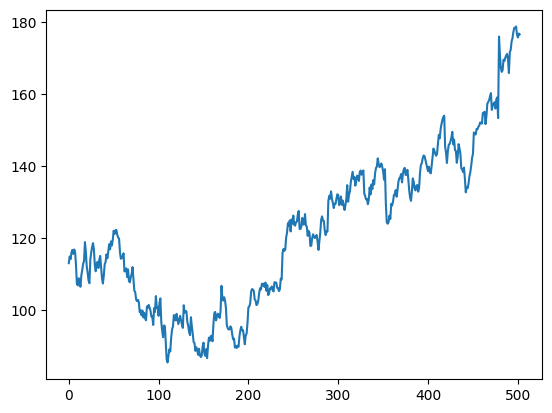

In [85]:
hist.y.plot()

In [80]:
data_combination=hist
k = 1                                          # Forecast 1 step ahead
forecast_start = 0 
forecast_end = data_combination.shape[0]-1
data_combination
# Model Base
mod, samples = analysis(data_combination['y'].values, 
                        #data_combination[exog_cols].values, 
                        family="poisson",
                        forecast_start=forecast_start,      # First time step to forecast on
                        forecast_end=forecast_end,          # Final time step to forecast on
                        k=1,                                # Forecast horizon. If k>1, default is to forecast 1:k steps ahead, marginally
                        prior_length=5,                     # How many data point to use in defining prior
                        rho=.5,                             # Random effect extension, which increases the forecast variance (see Berry and West, 2019)
                        deltrend=0.95,                      # Discount factor on the trend component (the intercept)
                        delregn=0.95                        # Discount factor on the regression component
)

In [88]:
pred_0=np.median(mod.forecast_marginal(k=1,nsamps=100))
mod.update(y=pred_0)

In [89]:
lista_forecasts=[]
lista_forecasts.append(pred_0)
for i in range(13-1):
    #print('Procesando iteracion: ',i+1)
    pred_i= np.median(mod.forecast_marginal(k=1,nsamps=1000))
    lista_forecasts.append(pred_i)
    mod.update(y=pred_i)

In [90]:
lista_forecasts

[165.0,
 168.0,
 167.0,
 167.0,
 167.5,
 167.0,
 168.0,
 168.0,
 167.0,
 167.0,
 167.0,
 168.0,
 168.0]

In [92]:
t=pd.DataFrame()
t['pred']=lista_forecasts
t     

,pred
0,165.0
1,168.0
2,167.0
3,167.0
4,167.5
5,167.0
6,168.0
7,168.0
8,167.0
9,167.0


# 5. Skforecast

**Referencia:** https://skforecast.org/0.12.1/index.html

## 5.1 Evaluación

In [77]:
T=C_weekly[['ds','y']].iloc[0:-15].fillna(method='backfill').fillna(method='bfill').fillna(method='ffill')
T['ds'] = pd.to_datetime(T['ds'] + '-1', format='%Y-%W-%w')
T['ds_new']= np.arange(0, T.shape[0],1)
T

,ds,y,ds_new
0,2022-05-30,114.547752,0
1,2022-06-06,115.677951,1
2,2022-06-13,107.584000,2
3,2022-06-20,111.854500,3
4,2022-06-27,113.254198,4
...,...,...,...
85,2024-01-15,144.021248,85
86,2024-01-22,150.266000,86
87,2024-01-29,147.523999,87
88,2024-02-05,146.207999,88


In [114]:
forecaster= ForecasterAutoreg(
    regressor =CatBoostRegressor(random_state= 123, silent=True), 
    lags= 24,
    #transformer_y = PowerTransformer()
)

param_grid= {'n_estimators': [30,50,100],'max_depth':[5, 10],'learning_rate':[0.1, 0.01]}
lags_grid =[1,3,6,12,24]

result_grid= grid_search_forecaster(
            forecaster= forecaster,
            y= T['y'],
            #exog= data_train[exog_cols],
            param_grid= param_grid,
            lags_grid= lags_grid,
            steps=steps_to_predict,
            #refit=True,
            metric= 'mean_squared_error',
            initial_train_size= int(len(T)*0.7),
            return_best=True,
            n_jobs='auto',
            verbose=False,
            show_progress= False
)
path_model= f"./model_CatBoost_GLOBAL_F.py"
save_forecaster(forecaster, file_name=path_model, verbose=False)

ruta_exog=f"./model_CatBoost_GLOBAL_F.py"
forecaster_loaded = load(f"{ruta_exog}")

Number of models compared: 60.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 105.89673868955106



In [185]:
# Crear y entrenar forecaster
dss= list(T.ds_new)
ys= list(T.y)
preds= []
# ==============================================================================
for i in range(15):
   forecaster = ForecasterAutoreg(
                  #regressor = CatBoostRegressor(random_state= 123, silent=True, learning_rate=0.1, max_depth=10, n_estimators=100),
                  regressor = XGBRegressor(random_state= 123, silent=True, learning_rate=0.1, max_depth=10, n_estimators=50),
                  lags =1
               )
   U=pd.DataFrame()
   U['ds']= dss 
   U['y']= ys
   #U= U.set_index('ds')
   forecaster.fit(y=U['y'])
   predicciones = forecaster.predict(steps=1).values[0]
   dss.append(U['ds'].max()+1)
   ys.append(predicciones)
   preds.append(predicciones)
   print(preds)
   

[146.11669921875]
[146.11669921875, 148.1322784423828]
[146.11669921875, 148.1322784423828, 146.0471954345703]
[146.11669921875, 148.1322784423828, 146.0471954345703, 148.3510284423828]
[146.11669921875, 148.1322784423828, 146.0471954345703, 148.3510284423828, 146.00357055664062]
[146.11669921875, 148.1322784423828, 146.0471954345703, 148.3510284423828, 146.00357055664062, 148.46685791015625]
[146.11669921875, 148.1322784423828, 146.0471954345703, 148.3510284423828, 146.00357055664062, 148.46685791015625, 145.9591522216797]
[146.11669921875, 148.1322784423828, 146.0471954345703, 148.3510284423828, 146.00357055664062, 148.46685791015625, 145.9591522216797, 148.5647735595703]
[146.11669921875, 148.1322784423828, 146.0471954345703, 148.3510284423828, 146.00357055664062, 148.46685791015625, 145.9591522216797, 148.5647735595703, 145.91070556640625]
[146.11669921875, 148.1322784423828, 146.0471954345703, 148.3510284423828, 146.00357055664062, 148.46685791015625, 145.9591522216797, 148.564773

In [186]:
f_t= pd.DataFrame()
f_t['pred']= preds
f_t['ds_new']= np.arange(T['ds_new'].max()+1,T['ds_new'].max()+1+15)


fig = go.Figure()
# Open
fig.add_trace(go.Scatter(x=C_weekly.iloc[0:-15]['ds_new'], y=C_weekly.iloc[0:-15]['y'], mode='lines', name='Open',
                         line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=f_t[['ds_new','pred']]['ds_new'], y=f_t[['ds_new','pred']]['pred'], mode='lines', name='Pred',
                         line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(x=C_weekly.iloc[-15:]['ds_new'], y=C_weekly.iloc[-15:]['y'], mode='lines', name='Test',
                         line=dict(color='green', width=2)))

# Layout
fig.update_layout(
    title='MSFT history',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    #template='plotly_dark', 
    hovermode='x'
)
fig.show()

In [189]:
print('MSE: ', mean_squared_error(y_true=C_weekly.iloc[-15:]['y'].values, y_pred=f_t['pred'].values))
print('RMSE: ', np.sqrt(mean_squared_error(y_true=C_weekly.iloc[-15:]['y'].values, y_pred=f_t['pred'].values)))
print('MAE: ', mean_absolute_error(y_true=C_weekly.iloc[-15:]['y'].values, y_pred=f_t['pred'].values))
print('Max Error: ', max_error(y_true=C_weekly.iloc[-15:]['y'].values, y_pred=f_t['pred'].values))
print('MAPE: ', mean_absolute_percentage_error(y_true=C_weekly.iloc[-15:]['y'].values, y_pred=f_t['pred'].values)*100)

MSE:  276.23882469764726
RMSE:  16.620433950340985
MAE:  13.790464918348528
Max Error:  30.627049763997405
MAPE:  8.44555146261603
